# 决策树(ID3)
> KNN最大的缺点在于算法的可解释性差，而决策树最大优势在于**可解释性强**
- 优点
    - 计算复杂度低
    - 输出结构易于理解
    - 对中间值的缺失不敏感
    - 可以处理不相关特征数据
- 缺点
    - 可能产生过度匹配问题
- 适用数据类型
    - 数值型
    - 标称型

## 信息熵
熵定义为信息的期望，符号$x_i$的信息定义为
$$
    I(x_i) = -log_2p(x_i)
$$
为了计算熵，我们要计算所有类别所有可能包含的信息的期望值,n为分类的数目
$$
    H = -\sum^n_{i=1}{p(x_i)log_2p(x_i)}
$$

In [1]:
def createDataSet():
    
    dataSet = [[1,1,'yes'],[1,1,'yes'],\
              [1,0,'no'],[0,1,'no'],[0,1,'no'] ]
    labels = ['no surfacing','flippers']
    
    return dataSet,labels

myDat,labels = createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [2]:
# 计算香农熵
from math import log
def calcShannonEnt(dataSet):
    numEnt = len(dataSet)
    labelCounts = {}
    # 统计数据
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    # 计算信息熵
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEnt
        shannonEnt -= prob * log(prob,2)
    return shannonEnt

calcShannonEnt(myDat)

0.9709505944546686

In [3]:
myDat[0][-1] = 'no'
calcShannonEnt(myDat)

0.7219280948873623

In [4]:
myDat[0][-1] = 'maybe'
calcShannonEnt(myDat)

1.3709505944546687

**由此可见数据越混乱，信息熵越大**

## 划分数据集
- 划分数据集
- 度量划分数据集的熵

我们将对每个特征划分数据集的结果计算一次信息熵，然后判断哪个特征划分数据集是最好的划分方式

In [5]:
def splitDataSet(dataSet,axis,value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

myDat,labels = createDataSet()                                  
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [6]:
splitDataSet(myDat,0,1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [7]:
splitDataSet(myDat,0,0)

[[1, 'no'], [1, 'no']]

In [8]:
# 基于信息增益选择最优特征
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEnt = calcShannonEnt(dataSet)
    dataSetNum = len(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEnt = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet,i,value)
            prob = len(subDataSet)/float(dataSetNum)
            newEnt += prob * calcShannonEnt(subDataSet)

        infoGain = baseEnt - newEnt
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
        return bestFeature
    
chooseBestFeatureToSplit(myDat)

0

## 递归构建决策树
- 决策树本身是树结构，利用递归构建不失为一个简单易懂的方式
- 由于特征的值可能多余两个因此可能存在大于两个分支的数据划分
- 划分过后数据被向下传递到树分支的下一个节点，在对应节点上可以在此划分数据
- 任何叶子节点的数据必然属于叶子结点的分类
- 使用了所有特征，类标签仍旧不唯一，通常采用多数表决

In [9]:
import operator
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(),key = operator.itemgetter(1),reverse = True)
    return sortedClassCount[0][0]

In [10]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]

    # 叶节点样本都属于统一类别的时候返回
    setClassList = set(classList)
    if len(setClassList)==1:
        return classList.pop()

    # 遍历玩所有特征时候返回出现次数最多的类标签
    if len(dataSet[0])==1:
        return majorityCnt(classList)

    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatBabel = labels[bestFeat]

    myTree = {bestFeatBabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatBabel][value] = createTree(splitDataSet(dataSet,bestFeat,value),subLabels)
    return myTree

In [11]:
myDat,labels = createDataSet()
myTree = createTree(myDat,labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# matplotLib形象化决策树

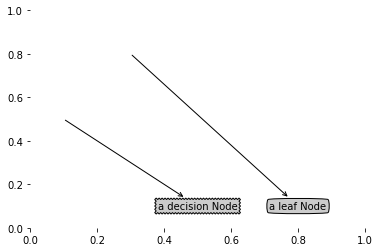

In [12]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle = 'sawtooth',fc = '0.8')
leafNode = dict(boxstyle = 'round4',fc='0.8')
arrow_args = dict(arrowstyle = '<-')

def plotNode(subfig,nodeTxt,centerPt,parentPt,nodeType):
    subfig.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',\
                           xytext=centerPt,textcoords='axes fraction',\
                           va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)
    
    
def createPlot():
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    subfig = plt.subplot(111,frameon = False)
    plotNode(subfig,'a decision Node',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode(subfig,'a leaf Node',(0.8,0.1),(0.3,0.8),leafNode)
    plt.show()
createPlot()

## 获取节点数目和树的层数

In [13]:
# 获取叶节点数目
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if isinstance(secondDict[key],dict):
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if isinstance(secondDict[key],dict):
            depth = 1 + getTreeDepth(secondDict[key])
        else:
            depth = 1
    if maxDepth>depth:
        return maxDepth
    else:
        return depth

In [14]:
def retrieveTree(i):
    listOfTrees =[\
                {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},\
                {'no surfacing': {0: 'no', 1: \
                      {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}\
                  ]
    return listOfTrees[i]
myTree = retrieveTree(0)
print(myTree)
print(getNumLeafs(myTree))
print(getTreeDepth(myTree))

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
3
2


## 绘制决策树

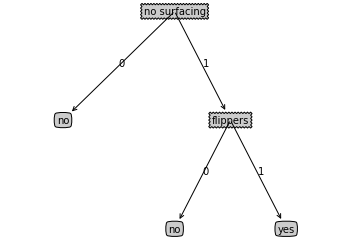

In [15]:
# 在父子节点之间填充文本信息
def plotMidText(cntrPt,parentPt,txtString,TreeAtt):
    xMid = (parentPt[0]-cntrPt[0])/2 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2 + cntrPt[1]
    TreeAtt['fig'].text(xMid,yMid,txtString)
    
def plotTree(myTree,parentPt,nodeTxt,TreeAtt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    
    # 绘制选择节点
    firstStr = list(myTree.keys())[0]
    cntrPt = (TreeAtt['xOff']+(1.0 + float(numLeafs))/2/TreeAtt['totalW'] , TreeAtt['yOff'])
    plotMidText(cntrPt, parentPt, nodeTxt,TreeAtt)
    plotNode(TreeAtt['fig'],firstStr, cntrPt, parentPt, decisionNode)
    
    secondDict = myTree[firstStr]
    TreeAtt['yOff'] = TreeAtt['yOff'] - 1.0/TreeAtt['totalD']
    for key in secondDict.keys():
        if isinstance(secondDict[key],dict):
            # 依据根绘制树
            plotTree(secondDict[key],cntrPt,str(key),TreeAtt)
        else:
            # 绘制属性线
            TreeAtt['xOff'] = TreeAtt['xOff'] + 1.0/TreeAtt['totalW']
            plotNode(TreeAtt['fig'],secondDict[key], (TreeAtt['xOff'], TreeAtt['yOff']), cntrPt, leafNode)
            plotMidText((TreeAtt['xOff'], TreeAtt['yOff']), cntrPt, str(key),TreeAtt)
    
    # 回溯完了之后恢复y轴绘图坐标
    TreeAtt['yOff'] = TreeAtt['yOff'] + 1.0/TreeAtt['totalD']
    
def createPlot(inTree):
    fig = plt.figure(1,facecolor='white')
    # 清除数据     
    fig.clf()
    TreeAtt = {}
    TreeAtt['fig'] = plt.subplot(111,frameon=False,xticks = [],yticks = [])
    TreeAtt['totalW'] = float(getNumLeafs(inTree))
    TreeAtt['totalD'] = float(getTreeDepth(inTree))
    TreeAtt['xOff'] = -0.5 / TreeAtt['totalW']
    TreeAtt['yOff'] = 1.0
    
    plotTree(inTree,(0.5,1.0),'',TreeAtt)
    plt.show()
    
createPlot(myTree)

In [16]:
myTree['no surfacing'][3] = 'maybe'
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}

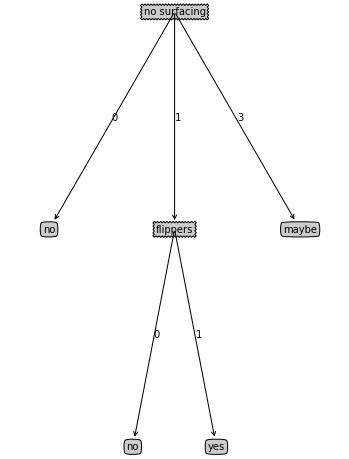

In [17]:
createPlot(myTree)

# 测试及存储分类器

## 测试分类器

In [18]:
def classify(inputTree,featLabels,testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex]==key:
            if isinstance(secondDict[key],dict):
                classLabel = classify(secondDict[key],featLabels,testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [19]:
myDat,labels = createDataSet()
myTree = retrieveTree(0)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [20]:
labels

['no surfacing', 'flippers']

In [21]:
print(classify(myTree,labels,[1,0]))
print(classify(myTree,labels,[1,1]))

no
yes


## 使用算法:存储决策树

In [22]:
# 使用pickle序列化对象
import pickle
def storeTree(inputTree,filename):
    fw = open(filename,'wb')
    pickle.dump(inputTree,fw)
    fw.close()

def grabTree(filename):
    fr = open(filename,'rb')
    return pickle.load(fr)

storeTree(myTree,'../data/DecTree/classifierStorage.txt')


In [23]:
grabTree('../data/DecTree/classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# e.g. 使用决策树预测隐形眼镜类型
隐形眼镜数据集包含很多患者眼部状况的观察条件及医生推荐的隐形眼镜类别
> The dataset is a modified version of the Lenses dataset retrieved from the UCI Machine Learning Repository November 3，
2010 [http://archive.ics.uci.edu/mVmachine-leaming-databases/lenses^|. The source of the data is Jadzia Cendrowska and
was originally published in UPRISM: An algorithm for inducing modular rules,” in International Journal o f Man-Machine
S(udies(i9%ll 27,349-70.)

In [24]:
fr = open('../data/DecTree/lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age','prescript','astigmatic','tearRate']
lensesTree = createTree(lenses,lensesLabels)
lensesTree

{'age': {'pre': {'prescript': {'hyper': {'astigmatic': {'no': {'tearRate': {'normal': 'soft',
        'reduced': 'no lenses'}},
      'yes': 'no lenses'}},
    'myope': {'astigmatic': {'no': {'tearRate': {'normal': 'soft',
        'reduced': 'no lenses'}},
      'yes': {'tearRate': {'normal': 'hard', 'reduced': 'no lenses'}}}}}},
  'young': {'tearRate': {'soft': 'soft',
    'hard': 'hard',
    'no lenses': 'no lenses'}},
  'presbyopic': {'prescript': {'hyper': {'astigmatic': {'no': {'tearRate': {'normal': 'soft',
        'reduced': 'no lenses'}},
      'yes': 'no lenses'}},
    'myope': {'astigmatic': {'no': 'no lenses',
      'yes': {'tearRate': {'normal': 'hard', 'reduced': 'no lenses'}}}}}}}}

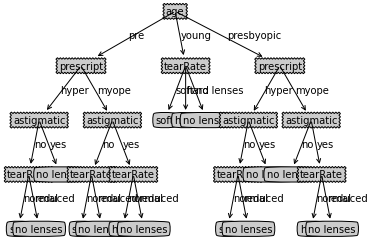

In [25]:
createPlot(lensesTree)

# 总结
- 决策树很好的匹配了实验数据，然而这些匹配选项可能过多。该现象被称为overfitting
- 可以裁剪决策树，减少过度匹配问题去掉不必要的叶子结点
- 叶子结点只增加少量信息，也可以删除，并将其归入到其他叶子节点中
- ID3好而不完美，无法处理数值类型数据，尽管可以将数值型转换成标称型，但存在太多划分，ID3仍旧面对其它问题